In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\原数据\K_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[11].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers:
        layer.trainable = False
    #Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    #global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    #prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        #Dense,
        #layers.Dropout(0.5),
        #global_average_layer,
        #prediction_layer
    ])
    base_learning_rate = 0.01
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model1.summary()
    return model1

In [4]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [5]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [6]:
batch_size=256

In [7]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [8]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [9]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [10]:
prediction_result_cv = []
prediction_result_ind = []

In [11]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try')

In [12]:
out = os.getcwd() + '\\'

In [13]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0     

8/8 - 0s - loss: 0.5646 - accuracy: 0.7088 - val_loss: 0.5977 - val_accuracy: 0.7378

Epoch 00038: val_loss did not improve from 0.59774
Epoch 39/300
8/8 - 0s - loss: 0.5746 - accuracy: 0.7000 - val_loss: 0.5977 - val_accuracy: 0.7378

Epoch 00039: val_loss did not improve from 0.59774
Epoch 40/300
8/8 - 0s - loss: 0.5653 - accuracy: 0.7054 - val_loss: 0.5977 - val_accuracy: 0.7378

Epoch 00040: val_loss did not improve from 0.59774
Epoch 41/300
8/8 - 0s - loss: 0.5679 - accuracy: 0.7029 - val_loss: 0.5977 - val_accuracy: 0.7378

Epoch 00041: val_loss did not improve from 0.59774
Epoch 42/300
8/8 - 0s - loss: 0.5667 - accuracy: 0.7148 - val_loss: 0.5977 - val_accuracy: 0.7378

Epoch 00042: val_loss did not improve from 0.59774
Epoch 43/300
8/8 - 0s - loss: 0.5660 - accuracy: 0.7039 - val_loss: 0.5977 - val_accuracy: 0.7378

Epoch 00043: val_loss did not improve from 0.59774
Epoch 44/300
8/8 - 0s - loss: 0.5731 - accuracy: 0.7029 - val_loss: 0.5977 - val_accuracy: 0.7378

Epoch 00044: v

8/8 - 0s - loss: 0.5657 - accuracy: 0.7098 - val_loss: 0.5729 - val_accuracy: 0.7111

Epoch 00024: val_loss did not improve from 0.57288
Epoch 25/300
8/8 - 0s - loss: 0.5704 - accuracy: 0.6965 - val_loss: 0.5729 - val_accuracy: 0.7111

Epoch 00025: val_loss did not improve from 0.57288
Epoch 26/300
8/8 - 0s - loss: 0.5718 - accuracy: 0.7079 - val_loss: 0.5729 - val_accuracy: 0.7111

Epoch 00026: val_loss did not improve from 0.57288
Epoch 27/300
8/8 - 0s - loss: 0.5679 - accuracy: 0.7202 - val_loss: 0.5729 - val_accuracy: 0.7111

Epoch 00027: val_loss did not improve from 0.57288
Epoch 28/300
8/8 - 0s - loss: 0.5730 - accuracy: 0.7103 - val_loss: 0.5729 - val_accuracy: 0.7111

Epoch 00028: val_loss did not improve from 0.57288
Epoch 29/300
8/8 - 0s - loss: 0.5648 - accuracy: 0.7138 - val_loss: 0.5729 - val_accuracy: 0.7111

Epoch 00029: val_loss did not improve from 0.57288
Epoch 30/300
8/8 - 0s - loss: 0.5693 - accuracy: 0.7093 - val_loss: 0.5729 - val_accuracy: 0.7111

Epoch 00030: v

8/8 - 0s - loss: 0.5775 - accuracy: 0.7004 - val_loss: 0.5759 - val_accuracy: 0.7200

Epoch 00010: val_loss did not improve from 0.57585
Epoch 11/300
8/8 - 0s - loss: 0.5666 - accuracy: 0.7118 - val_loss: 0.5759 - val_accuracy: 0.7200

Epoch 00011: val_loss did not improve from 0.57585
Epoch 12/300
8/8 - 0s - loss: 0.5678 - accuracy: 0.7079 - val_loss: 0.5759 - val_accuracy: 0.7200

Epoch 00012: val_loss did not improve from 0.57585
Epoch 13/300
8/8 - 0s - loss: 0.5818 - accuracy: 0.6970 - val_loss: 0.5759 - val_accuracy: 0.7200

Epoch 00013: val_loss did not improve from 0.57585
Epoch 14/300
8/8 - 0s - loss: 0.5739 - accuracy: 0.6960 - val_loss: 0.5759 - val_accuracy: 0.7200

Epoch 00014: val_loss did not improve from 0.57585
Epoch 15/300
8/8 - 0s - loss: 0.5707 - accuracy: 0.7148 - val_loss: 0.5759 - val_accuracy: 0.7200

Epoch 00015: val_loss did not improve from 0.57585
Epoch 16/300
8/8 - 0s - loss: 0.5640 - accuracy: 0.7059 - val_loss: 0.5759 - val_accuracy: 0.7200

Epoch 00016: v

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 1)                 208001    
Total params: 208,001
Trainable params: 0
Non-trainable params: 208,001
_________________________________________________________________
Epoch 1/300
8/8 - 0s - loss: 0.5753 - accuracy: 0.7044 - val_loss: 0.5801 - val_accuracy: 0.7022

Epoch 00001: val_loss improved from inf to 0.58005, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try\_3.h5
Epoch 2/300
8/8 - 0s - loss: 0.5769 - accuracy: 0.6945 - val_loss: 0.5801 - val_accuracy: 0.7022

Epoch 00002: val_loss did not improve from 0.58005
Epoch 3/300
8/8 - 0s - loss: 0.5631 - accuracy: 0.7173 - val_loss: 0.5801 - val_accuracy: 0.7022

Epoch 00003: val_loss did not improve from 0.58005
Epoch 4/300
8/8 - 0s - loss: 0.5646 - accuracy: 0.7079 -


Epoch 00051: val_loss did not improve from 0.58005
4
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_p


Epoch 00037: val_loss did not improve from 0.57858
Epoch 38/300
8/8 - 0s - loss: 0.5717 - accuracy: 0.7000 - val_loss: 0.5786 - val_accuracy: 0.7200

Epoch 00038: val_loss did not improve from 0.57858
Epoch 39/300
8/8 - 0s - loss: 0.5746 - accuracy: 0.6995 - val_loss: 0.5786 - val_accuracy: 0.7200

Epoch 00039: val_loss did not improve from 0.57858
Epoch 40/300
8/8 - 0s - loss: 0.5666 - accuracy: 0.7138 - val_loss: 0.5786 - val_accuracy: 0.7200

Epoch 00040: val_loss did not improve from 0.57858
Epoch 41/300
8/8 - 0s - loss: 0.5666 - accuracy: 0.7064 - val_loss: 0.5786 - val_accuracy: 0.7200

Epoch 00041: val_loss did not improve from 0.57858
Epoch 42/300
8/8 - 0s - loss: 0.5736 - accuracy: 0.6950 - val_loss: 0.5786 - val_accuracy: 0.7200

Epoch 00042: val_loss did not improve from 0.57858
Epoch 43/300
8/8 - 0s - loss: 0.5753 - accuracy: 0.7000 - val_loss: 0.5786 - val_accuracy: 0.7200

Epoch 00043: val_loss did not improve from 0.57858
Epoch 44/300
8/8 - 0s - loss: 0.5778 - accuracy:


Epoch 00018: val_loss did not improve from 0.58695
Epoch 19/300
8/8 - 0s - loss: 0.5656 - accuracy: 0.7079 - val_loss: 0.5869 - val_accuracy: 0.7156

Epoch 00019: val_loss did not improve from 0.58695
Epoch 20/300
8/8 - 0s - loss: 0.5677 - accuracy: 0.7034 - val_loss: 0.5869 - val_accuracy: 0.7156

Epoch 00020: val_loss did not improve from 0.58695
Epoch 21/300
8/8 - 0s - loss: 0.5755 - accuracy: 0.7034 - val_loss: 0.5869 - val_accuracy: 0.7156

Epoch 00021: val_loss did not improve from 0.58695
Epoch 22/300
8/8 - 0s - loss: 0.5738 - accuracy: 0.7029 - val_loss: 0.5869 - val_accuracy: 0.7156

Epoch 00022: val_loss did not improve from 0.58695
Epoch 23/300
8/8 - 0s - loss: 0.5740 - accuracy: 0.7093 - val_loss: 0.5869 - val_accuracy: 0.7156

Epoch 00023: val_loss did not improve from 0.58695
Epoch 24/300
8/8 - 0s - loss: 0.5714 - accuracy: 0.7054 - val_loss: 0.5869 - val_accuracy: 0.7156

Epoch 00024: val_loss did not improve from 0.58695
Epoch 25/300
8/8 - 0s - loss: 0.5760 - accuracy:

8/8 - 0s - loss: 0.5706 - accuracy: 0.7044 - val_loss: 0.5588 - val_accuracy: 0.7378

Epoch 00001: val_loss improved from inf to 0.55882, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try\_6.h5
Epoch 2/300
8/8 - 0s - loss: 0.5761 - accuracy: 0.6980 - val_loss: 0.5588 - val_accuracy: 0.7378

Epoch 00002: val_loss did not improve from 0.55882
Epoch 3/300
8/8 - 0s - loss: 0.5753 - accuracy: 0.6965 - val_loss: 0.5588 - val_accuracy: 0.7378

Epoch 00003: val_loss did not improve from 0.55882
Epoch 4/300
8/8 - 0s - loss: 0.5767 - accuracy: 0.7004 - val_loss: 0.5588 - val_accuracy: 0.7378

Epoch 00004: val_loss did not improve from 0.55882
Epoch 5/300
8/8 - 0s - loss: 0.5763 - accuracy: 0.7133 - val_loss: 0.5588 - val_accuracy: 0.7378

Epoch 00005: val_loss did not improve from 0.55882
Epoch 6/300
8/8 - 0s - loss: 0.5722 - accuracy: 0.7044 - val_loss: 0.5588 - val_accuracy: 0.7378

Epoch 00006: val_loss did not 

7
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0 

8/8 - 0s - loss: 0.5774 - accuracy: 0.7054 - val_loss: 0.5951 - val_accuracy: 0.6756

Epoch 00038: val_loss did not improve from 0.59514
Epoch 39/300
8/8 - 0s - loss: 0.5688 - accuracy: 0.7059 - val_loss: 0.5951 - val_accuracy: 0.6756

Epoch 00039: val_loss did not improve from 0.59514
Epoch 40/300
8/8 - 0s - loss: 0.5678 - accuracy: 0.7029 - val_loss: 0.5951 - val_accuracy: 0.6756

Epoch 00040: val_loss did not improve from 0.59514
Epoch 41/300
8/8 - 0s - loss: 0.5704 - accuracy: 0.7014 - val_loss: 0.5951 - val_accuracy: 0.6756

Epoch 00041: val_loss did not improve from 0.59514
Epoch 42/300
8/8 - 0s - loss: 0.5635 - accuracy: 0.7098 - val_loss: 0.5951 - val_accuracy: 0.6756

Epoch 00042: val_loss did not improve from 0.59514
Epoch 43/300
8/8 - 0s - loss: 0.5688 - accuracy: 0.7049 - val_loss: 0.5951 - val_accuracy: 0.6756

Epoch 00043: val_loss did not improve from 0.59514
Epoch 44/300
8/8 - 0s - loss: 0.5729 - accuracy: 0.7029 - val_loss: 0.5951 - val_accuracy: 0.6756

Epoch 00044: v

8/8 - 0s - loss: 0.5797 - accuracy: 0.6947 - val_loss: 0.5564 - val_accuracy: 0.7768

Epoch 00019: val_loss did not improve from 0.55645
Epoch 20/300
8/8 - 0s - loss: 0.5812 - accuracy: 0.6957 - val_loss: 0.5564 - val_accuracy: 0.7768

Epoch 00020: val_loss did not improve from 0.55645
Epoch 21/300
8/8 - 0s - loss: 0.5756 - accuracy: 0.6971 - val_loss: 0.5564 - val_accuracy: 0.7768

Epoch 00021: val_loss did not improve from 0.55645
Epoch 22/300
8/8 - 0s - loss: 0.5747 - accuracy: 0.7060 - val_loss: 0.5564 - val_accuracy: 0.7768

Epoch 00022: val_loss did not improve from 0.55645
Epoch 23/300
8/8 - 0s - loss: 0.5817 - accuracy: 0.6996 - val_loss: 0.5564 - val_accuracy: 0.7768

Epoch 00023: val_loss did not improve from 0.55645
Epoch 24/300
8/8 - 0s - loss: 0.5796 - accuracy: 0.6991 - val_loss: 0.5564 - val_accuracy: 0.7768

Epoch 00024: val_loss did not improve from 0.55645
Epoch 25/300
8/8 - 0s - loss: 0.5725 - accuracy: 0.7016 - val_loss: 0.5564 - val_accuracy: 0.7768

Epoch 00025: v

8/8 - 0s - loss: 0.5745 - accuracy: 0.7065 - val_loss: 0.5682 - val_accuracy: 0.7411

Epoch 00001: val_loss improved from inf to 0.56816, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try\_9.h5
Epoch 2/300
8/8 - 0s - loss: 0.5717 - accuracy: 0.7115 - val_loss: 0.5682 - val_accuracy: 0.7411

Epoch 00002: val_loss did not improve from 0.56816
Epoch 3/300
8/8 - 0s - loss: 0.5774 - accuracy: 0.6986 - val_loss: 0.5682 - val_accuracy: 0.7411

Epoch 00003: val_loss did not improve from 0.56816
Epoch 4/300
8/8 - 0s - loss: 0.5767 - accuracy: 0.7120 - val_loss: 0.5682 - val_accuracy: 0.7411

Epoch 00004: val_loss did not improve from 0.56816
Epoch 5/300
8/8 - 0s - loss: 0.5794 - accuracy: 0.7085 - val_loss: 0.5682 - val_accuracy: 0.7411

Epoch 00005: val_loss did not improve from 0.56816
Epoch 6/300
8/8 - 0s - loss: 0.5763 - accuracy: 0.6947 - val_loss: 0.5682 - val_accuracy: 0.7411

Epoch 00006: val_loss did not 

10


In [14]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [15]:
roc_auc_list_val

[0.765091656131479,
 0.7953603316326531,
 0.7868204804045512,
 0.7860303413400759,
 0.7880056890012642,
 0.777496839443742,
 0.7773388116308471,
 0.8260113780025284,
 0.7710176991150443,
 0.8274872448979592]

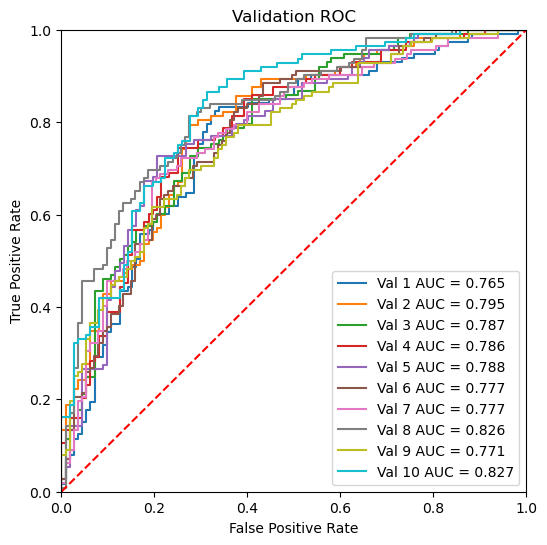

In [16]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

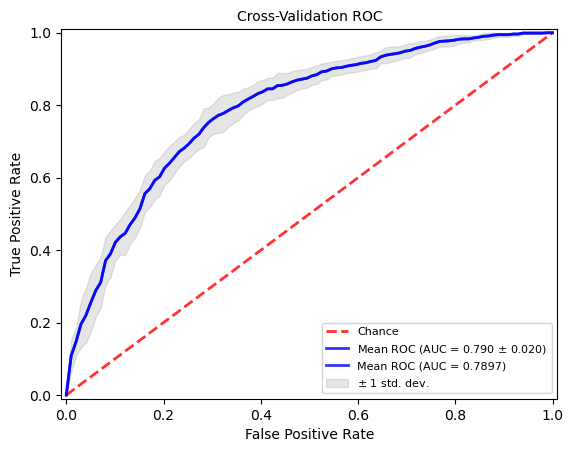

In [17]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [18]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [19]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [20]:
my_calculate_metrics_list_val

[{'SN': 0.831858407079646,
  'SP': 0.6428571428571429,
  'ACC': 0.7377777777777778,
  'MCC': 0.4836248361323207,
  'Recall': 0.831858407079646,
  'Precision': 0.7014925373134329,
  'F1-score': 0.7611336032388664,
  'Cutoff': 0.5},
 {'SN': 0.8571428571428571,
  'SP': 0.625,
  'ACC': 0.7410714285714286,
  'MCC': 0.49568410306397126,
  'Recall': 0.8571428571428571,
  'Precision': 0.6956521739130435,
  'F1-score': 0.768,
  'Cutoff': 0.5},
 {'SN': 0.7699115044247787,
  'SP': 0.6517857142857143,
  'ACC': 0.7111111111111111,
  'MCC': 0.424762433131509,
  'Recall': 0.7699115044247787,
  'Precision': 0.6904761904761905,
  'F1-score': 0.7280334728033473,
  'Cutoff': 0.5},
 {'SN': 0.8141592920353983,
  'SP': 0.625,
  'ACC': 0.72,
  'MCC': 0.4474012715085616,
  'Recall': 0.8141592920353983,
  'Precision': 0.6865671641791045,
  'F1-score': 0.7449392712550608,
  'Cutoff': 0.5},
 {'SN': 0.7964601769911505,
  'SP': 0.6071428571428571,
  'ACC': 0.7022222222222222,
  'MCC': 0.4111777068848026,
  'Recall

In [21]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.831858,0.642857,0.737778,0.483625,0.831858,0.701493,0.761134,0.5
1,0.857143,0.625000,0.741071,0.495684,0.857143,0.695652,0.768000,0.5
2,0.769912,0.651786,0.711111,0.424762,0.769912,0.690476,0.728033,0.5
3,0.814159,0.625000,0.720000,0.447401,0.814159,0.686567,0.744939,0.5
4,0.796460,0.607143,0.702222,0.411178,0.796460,0.671642,0.728745,0.5
5,0.839286,0.601770,0.720000,0.453821,0.839286,0.676259,0.749004,0.5
6,0.785714,0.646018,0.715556,0.435885,0.785714,0.687500,0.733333,0.5
7,0.839286,0.637168,0.737778,0.486274,0.839286,0.696296,0.761134,0.5
8,0.794643,0.557522,0.675556,0.362358,0.794643,0.640288,0.709163,0.5
9,0.866071,0.687500,0.776786,0.562614,0.866071,0.734848,0.795082,0.5


In [22]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.831858,0.642857,0.737778,0.483625,0.831858,0.701493,0.761134,0.5
1,0.857143,0.625000,0.741071,0.495684,0.857143,0.695652,0.768000,0.5
2,0.769912,0.651786,0.711111,0.424762,0.769912,0.690476,0.728033,0.5
3,0.814159,0.625000,0.720000,0.447401,0.814159,0.686567,0.744939,0.5
4,0.796460,0.607143,0.702222,0.411178,0.796460,0.671642,0.728745,0.5
5,0.839286,0.601770,0.720000,0.453821,0.839286,0.676259,0.749004,0.5
6,0.785714,0.646018,0.715556,0.435885,0.785714,0.687500,0.733333,0.5
7,0.839286,0.637168,0.737778,0.486274,0.839286,0.696296,0.761134,0.5
8,0.794643,0.557522,0.675556,0.362358,0.794643,0.640288,0.709163,0.5
9,0.866071,0.687500,0.776786,0.562614,0.866071,0.734848,0.795082,0.5


In [23]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [24]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [25]:
roc_auc_list_indep

[0.7680963010204084,
 0.7680963010204084,
 0.7680963010204084,
 0.7680963010204084,
 0.7680963010204084,
 0.7680963010204084,
 0.7680963010204084,
 0.7680963010204084,
 0.7680963010204084,
 0.7680963010204084]

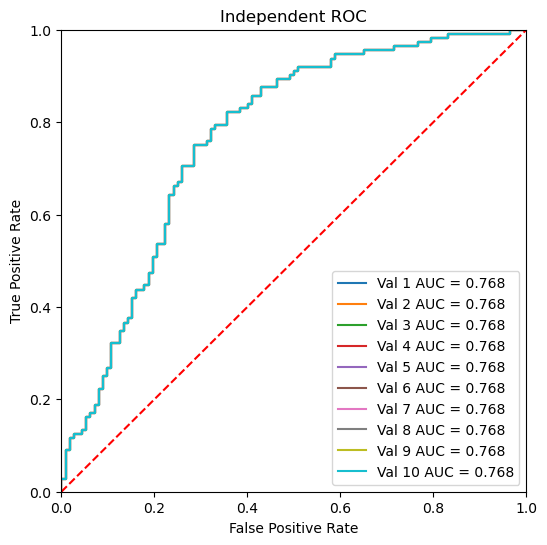

In [26]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

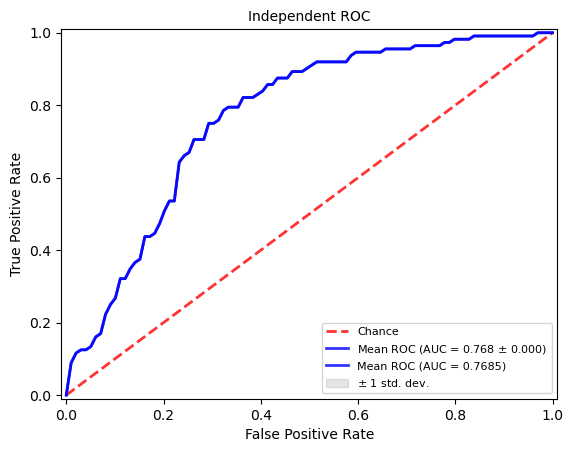

In [27]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [28]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [29]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [30]:
my_calculate_metrics_list_indep

[{'SN': 0.7946428571428571,
  'SP': 0.6696428571428571,
  'ACC': 0.7321428571428571,
  'MCC': 0.4679560142019004,
  'Recall': 0.7946428571428571,
  'Precision': 0.7063492063492064,
  'F1-score': 0.7478991596638656,
  'Cutoff': 0.5},
 {'SN': 0.7946428571428571,
  'SP': 0.6696428571428571,
  'ACC': 0.7321428571428571,
  'MCC': 0.4679560142019004,
  'Recall': 0.7946428571428571,
  'Precision': 0.7063492063492064,
  'F1-score': 0.7478991596638656,
  'Cutoff': 0.5},
 {'SN': 0.7946428571428571,
  'SP': 0.6696428571428571,
  'ACC': 0.7321428571428571,
  'MCC': 0.4679560142019004,
  'Recall': 0.7946428571428571,
  'Precision': 0.7063492063492064,
  'F1-score': 0.7478991596638656,
  'Cutoff': 0.5},
 {'SN': 0.7946428571428571,
  'SP': 0.6696428571428571,
  'ACC': 0.7321428571428571,
  'MCC': 0.4679560142019004,
  'Recall': 0.7946428571428571,
  'Precision': 0.7063492063492064,
  'F1-score': 0.7478991596638656,
  'Cutoff': 0.5},
 {'SN': 0.7946428571428571,
  'SP': 0.6696428571428571,
  'ACC': 0.7

In [31]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.794643,0.669643,0.732143,0.467956,0.794643,0.706349,0.747899,0.5
1,0.794643,0.669643,0.732143,0.467956,0.794643,0.706349,0.747899,0.5
2,0.794643,0.669643,0.732143,0.467956,0.794643,0.706349,0.747899,0.5
3,0.794643,0.669643,0.732143,0.467956,0.794643,0.706349,0.747899,0.5
4,0.794643,0.669643,0.732143,0.467956,0.794643,0.706349,0.747899,0.5
5,0.794643,0.669643,0.732143,0.467956,0.794643,0.706349,0.747899,0.5
6,0.794643,0.669643,0.732143,0.467956,0.794643,0.706349,0.747899,0.5
7,0.794643,0.669643,0.732143,0.467956,0.794643,0.706349,0.747899,0.5
8,0.794643,0.669643,0.732143,0.467956,0.794643,0.706349,0.747899,0.5
9,0.794643,0.669643,0.732143,0.467956,0.794643,0.706349,0.747899,0.5


In [32]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,7.946429e-01,6.696429e-01,7.321429e-01,0.467956,7.946429e-01,0.706349,0.747899,0.5
1,7.946429e-01,6.696429e-01,7.321429e-01,0.467956,7.946429e-01,0.706349,0.747899,0.5
2,7.946429e-01,6.696429e-01,7.321429e-01,0.467956,7.946429e-01,0.706349,0.747899,0.5
3,7.946429e-01,6.696429e-01,7.321429e-01,0.467956,7.946429e-01,0.706349,0.747899,0.5
4,7.946429e-01,6.696429e-01,7.321429e-01,0.467956,7.946429e-01,0.706349,0.747899,0.5
5,7.946429e-01,6.696429e-01,7.321429e-01,0.467956,7.946429e-01,0.706349,0.747899,0.5
6,7.946429e-01,6.696429e-01,7.321429e-01,0.467956,7.946429e-01,0.706349,0.747899,0.5
7,7.946429e-01,6.696429e-01,7.321429e-01,0.467956,7.946429e-01,0.706349,0.747899,0.5
8,7.946429e-01,6.696429e-01,7.321429e-01,0.467956,7.946429e-01,0.706349,0.747899,0.5
9,7.946429e-01,6.696429e-01,7.321429e-01,0.467956,7.946429e-01,0.706349,0.747899,0.5


In [33]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\try\freeze_allli_try\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

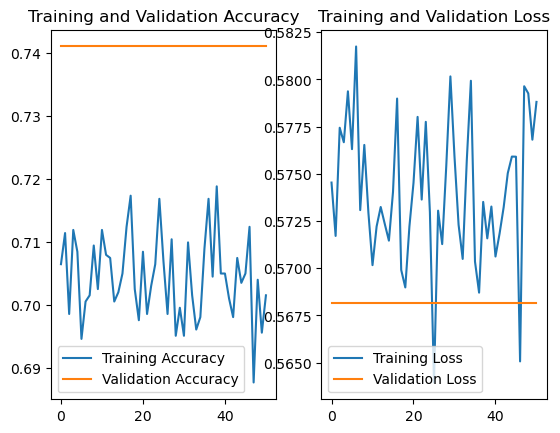

In [35]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()